### Infer motif models for fig 3

In [1]:
## Import necessary stuff. 

# Standard imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from dataclasses import dataclass
import time
import pickle

# Import x to one hot encoding
import utils 

# Logomaker
import logomaker

# jax import
import jax.random as random
import jax.numpy as jnp
from jax.numpy import DeviceArray

# numpyro imports
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, HMC, SVI
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

# arviz
#import arviz as az

# For visualization. Note that this notebook won't be making figure, so don't need to be picky. 
%matplotlib notebook

In [2]:
# Define type of model
#model_type = 'A' # Two-branaplam-mode model
model_type = 'C' # One-branaplam-mode model

# Define inference parameters
@dataclass
class args:
    num_chains = 4
    num_samples = 500 
    num_warmup = 500 
    device = 'cpu'
    progress_bar = True
    target_accept_prob = 0.8
numpyro.set_platform(args.device)
numpyro.set_host_device_count(args.num_chains)

In [3]:
# Set known motifs
wt_motif   = 'AGGA/GUAAGU'
cons_motif = 'NCAG/GUAAGU'
null_motif = 'NCAG/GGAAGA'

In [4]:
# Load MPSA data for SMN2

# Set file names
filenames = ['psi_smn2_dmso.csv',
             'psi_smn2_rg.csv',
             'psi_smn2_nvs.csv']
filenames = ['../data/mpsa/'+f for f in filenames]

# Load SMN2 data
for i, filename in enumerate(filenames):
    col = filename.split('/')[-1].split('.')[0][4:]
    tmp_df = pd.read_csv(filename, sep=',')

    # Rename splice sites
    tmp_df['ss'] = [s.replace('T','U') for s in tmp_df['ss']]
    tmp_df['ss'] = [s[:4]+'/'+s[4:] for s in tmp_df['ss']]
    tmp_df = tmp_df.set_index('ss')

    # Normalize each replicate by the median PSI of the 4 consensus sequences
    cons_ix = utils.motif_to_ix(cons_motif, tmp_df.index)
    cons_psi = tmp_df[cons_ix].median(axis=0)
    tmp_df.loc[:,:] = 100*tmp_df.values/cons_psi.values
    
    # Take median PSIs across columns
    if i==0:
        smn2_df = pd.DataFrame(index=tmp_df.index)
    smn2_df[col] = tmp_df.median(axis=1)
        
# Normalize AGAIN by median PSI
cons_ix = utils.motif_to_ix(cons_motif, smn2_df.index)
cons_psi = smn2_df[cons_ix].median(axis=0)
smn2_df.loc[:,:] = 100*smn2_df.values/cons_psi.values

# Verify that median PSI of consensus sequences is 100.0
cons_ix = utils.motif_to_ix(cons_motif, smn2_df.index)
assert(np.all(smn2_df[cons_ix].median(axis=0) == 100))

# Set sequences
seqs = smn2_df.index.values

# Set known motif indices and view quantities
wt_ix = utils.motif_to_ix(wt_motif, seqs)
cons_ix     = utils.motif_to_ix(cons_motif, seqs) 
null_ix     = utils.motif_to_ix(null_motif, seqs)

print(f'Num wildtype seqs: {sum(wt_ix)} ')
print(f'Num cons seqs: {sum(cons_ix)} ')
print(f'Num null seqs: {sum(null_ix)} ')

smn2_df.reset_index(inplace=True)
smn2_df.rename(columns = {'ss':'ss', 'smn2_dmso':'log_psi_dmso',
                          'smn2_rg': 'log_psi_risdiplam',
                          'smn2_nvs': 'log_psi_branaplam'},
              inplace=True)

# Filter sequences which has 10% Psi values of the median (background noise)
smn2_df['log_psi_dmso'] = np.log(smn2_df['log_psi_dmso'])
smn2_df['log_psi_risdiplam'] = np.log(smn2_df['log_psi_risdiplam'])
smn2_df['log_psi_branaplam'] = np.log(smn2_df['log_psi_branaplam'])

# Preview df
print(f'Total length of the MPSA dataset is : {len(smn2_df)}')
smn2_df.head()

Num wildtype seqs: 1 
Num cons seqs: 4 
Num null seqs: 4 
Total length of the MPSA dataset is : 285


/Users/jkinney/miniforge3_arm64/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ss,log_psi_dmso,log_psi_risdiplam,log_psi_branaplam
0,AAAA/GUAAGU,4.551940,4.317081,4.402211
1,AACA/GUAAGU,4.457342,4.277329,4.502020
2,AAGA/GUAAAU,-2.122804,-inf,-0.956345
3,AAGA/GUAACU,-1.567094,-inf,-1.563349
4,AAGA/GUAAGA,-0.701020,3.159262,4.343661


In [5]:
# Load RNA-seq data

# Read Risdiplam RNA-seq data and add GU
risdiplam_rnaseq = pd.read_csv('../data/rna-seq/risdiplam_rnaseq.csv')
risdiplam_rnaseq.rename(columns={'x': 'ss', 'y': 'log_E_risdiplam', 'dy':'dlog_E_risdiplam'}, inplace=True)

# Read Branaplam RNA-seq data and add GU
branaplam_rnaseq = pd.read_csv('../data/rna-seq/branaplam_rnaseq.csv')
branaplam_rnaseq.rename(columns={'x': 'ss', 'y': 'log_E_branaplam', 'dy':'dlog_E_branaplam'}, inplace=True)

# Merge RNAseq data for both drugs
rnaseq_df = risdiplam_rnaseq.merge(branaplam_rnaseq, on='ss', how='inner')
rnaseq_df['ss'] = rnaseq_df['ss'].str.replace('T', 'U')
rnaseq_df['ss'] = rnaseq_df['ss'].str[:4]+'/GU'+rnaseq_df['ss'].str[4:]

# Preview dataframe
print(f'Total length of the RNA-seq dataset is : {len(rnaseq_df)}')
rnaseq_df

Total length of the RNA-seq dataset is : 2545


,ss,log_E_risdiplam,dlog_E_risdiplam,log_E_branaplam,dlog_E_branaplam
0,AAAA/GUAAAA,0.508591,0.362189,1.437003,0.349206
1,AAAA/GUAAAG,0.725740,0.422907,0.215219,0.393041
2,AAAA/GUAAAU,0.121753,0.221160,0.795931,0.216936
3,AAAA/GUAACA,0.252730,0.753580,0.495291,0.704470
4,AAAA/GUAACU,-0.020570,0.284461,0.436673,0.278890
...,...,...,...,...,...
2540,UUUU/GUAAGA,0.032179,0.216037,-0.123883,0.213015
2541,UUUU/GUAAGC,0.161061,0.412960,0.369071,0.423659
2542,UUUU/GUAAGU,-0.180271,0.134436,-0.062364,0.137287
2543,UUUU/GUAUGU,-0.214805,0.144297,0.166181,0.139997


In [6]:
# Merge rnaseq and mpsa datasets
measurement_df = rnaseq_df.merge(smn2_df, how='outer', on='ss')
measurement_df.reset_index(inplace=True, drop=True)

# Mark which rows to use in different inference tasks
null_ix = utils.motif_to_ix(null_motif, measurement_df['ss'])
dmso_mpsa_bg = measurement_df['log_psi_dmso'][null_ix].median()
ris_mpsa_bg = measurement_df['log_psi_risdiplam'][null_ix].median()
bran_mpsa_bg = measurement_df['log_psi_branaplam'][null_ix].median()

# Mark which rows should be used for which inference tasks
shift = np.exp(0.1)

# Set flags for which data to use in each inference task.
measurement_df['use_for_mpsa_fit'] = (measurement_df['log_psi_dmso'] >= dmso_mpsa_bg+shift) &\
                                         (measurement_df['log_psi_risdiplam'] >= ris_mpsa_bg+shift) &\
                                          (measurement_df['log_psi_branaplam'] >= bran_mpsa_bg+shift) 
measurement_df['use_for_rnaseq_fit'] = measurement_df['log_E_risdiplam'].notna() &\
                                       measurement_df['log_E_branaplam'].notna()

# Print numer of measurements to use for each inference
for col in ['use_for_mpsa_fit', 'use_for_rnaseq_fit']:
    print(f'{col}: {measurement_df[col].sum():,} total measurements')

# Preview dataframe
print(f'Total length of the measurement dataset is : {len(measurement_df):,}')

# Save measurement_df
file_name = 'measurement_df.csv'
measurement_df.to_csv(file_name)
print(f'measurement_df saved to: {file_name}')
measurement_df.head()

use_for_mpsa_fit: 99 total measurements
use_for_rnaseq_fit: 2,545 total measurements
Total length of the measurement dataset is : 2,728
measurement_df saved to: measurement_df.csv


,ss,log_E_risdiplam,dlog_E_risdiplam,log_E_branaplam,dlog_E_branaplam,log_psi_dmso,log_psi_risdiplam,log_psi_branaplam,use_for_mpsa_fit,use_for_rnaseq_fit
0,AAAA/GUAAAA,0.508591,0.362189,1.437003,0.349206,NaN,NaN,NaN,False,True
1,AAAA/GUAAAG,0.725740,0.422907,0.215219,0.393041,NaN,NaN,NaN,False,True
2,AAAA/GUAAAU,0.121753,0.221160,0.795931,0.216936,NaN,NaN,NaN,False,True
3,AAAA/GUAACA,0.252730,0.753580,0.495291,0.704470,NaN,NaN,NaN,False,True
4,AAAA/GUAACU,-0.020570,0.284461,0.436673,0.278890,NaN,NaN,NaN,False,True


In [7]:
# Defines model using mask instead of indexing. Is much slower though. Don't use. 

# # Compute one-hot encoding of cropped sequences (i.e. without central '/GU')
# cropped_seqs = measurement_df['ss'].str[:4]+measurement_df['ss'].str[7:]
# ss_ohe = jnp.array(utils.x_to_ohe(cropped_seqs, alphabet_name='rna', ravel_seqs=False))

# # Define the model
# def model(model_type: str,
#           ss_ohe: DeviceArray = None,
#           measurement_df: pd.DataFrame = None) -> DeviceArray:

#     ## GP map parameters for both drugs risdiplam and hyper motif
#     theta_scale = 5
#     L=8
#     C=4
#     theta_0_hyp = numpyro.sample('theta_0_hyp', 
#                                  dist.Normal(loc=0, scale=theta_scale))
#     theta_lc_hyp = numpyro.sample('theta_lc_hyp', 
#                                   dist.Normal(loc=jnp.zeros((L,C)), scale=theta_scale))
#     theta_0_ris  = numpyro.sample('theta_0_ris', 
#                                   dist.Normal(loc=0, scale=theta_scale))
#     theta_lc_ris = numpyro.sample('theta_lc_ris', 
#                                   dist.Normal(loc=jnp.zeros((L,C)), scale=theta_scale))

#     # Get number of sequences
#     N = len(ss_ohe)

#     # Context strength
#     logS = numpyro.sample('logS', 
#                           dist.Normal(loc=jnp.zeros((N,)), 
#                           scale=theta_scale))
#     S = numpyro.deterministic('S', 
#                               jnp.exp(logS))

#     # phi values for ris and hyp motifs
#     phi_ris = numpyro.deterministic(
#                 'phi_ris', 
#                 theta_0_ris + jnp.einsum('nlc,lc->n', ss_ohe, theta_lc_ris))
#     phi_hyp = numpyro.deterministic(
#                 'phi_hyp', 
#                 theta_0_hyp + jnp.einsum('nlc,lc->n', ss_ohe, theta_lc_hyp))

#     # Risdiplam effect
#     E_ris = numpyro.deterministic('E_ris', 1+jnp.exp(phi_ris))

#     # Branaplam effect (depends on model)
#     if model_type=='A':
#         E_bra = numpyro.deterministic('E_bra', 1 + jnp.exp(phi_hyp) + jnp.exp(phi_ris))
#     elif model_type=='B':
#         E_bra = numpyro.deterministic('E_bra', 1 + jnp.exp(phi_hyp + phi_ris))
#     elif model_type=='C':
#         E_bra = numpyro.deterministic('E_bra', 1 + jnp.exp(phi_hyp))
        
#     # Drug strength: psi_drug = 100R/(R+1)+B
#     R_ris = numpyro.deterministic('R_ris', S*E_ris)        
#     R_bra = numpyro.deterministic('R_bra', S*E_bra)
    
#     # Background noise for MPSA dataset
#     B_ris = numpyro.sample('B_ris', dist.Exponential(1))
#     B_bra = numpyro.sample('B_bra', dist.Exponential(1))
#     B_dmso = numpyro.sample('B_dmso', dist.Exponential(1))

#     # Log PSI for DMSO, risdiplam, and branaplam 
#     log_psi_dmso = numpyro.deterministic('log_psi_dmso', jnp.log(100*S/(1+S) + B_dmso))
#     log_psi_ris  = numpyro.deterministic('log_psi_ris', jnp.log(100*(R_ris)/(1+R_ris) + B_ris))
#     log_psi_bra  = numpyro.deterministic('log_psi_bra', jnp.log(100*(R_bra)/(1+R_bra) + B_bra))
    
#     # Log E for risdiplam and branaplam
#     log_E_ris = numpyro.deterministic('log_E_ris', jnp.log(E_ris))
#     log_E_bra = numpyro.deterministic('log_E_bra', jnp.log(E_bra))
    
#     # Noise magnitude for MPSA meausurements of log PSI
#     sigma_mpsa_dmso = numpyro.sample('sigma_mpsa_dmso', dist.Exponential(1))
#     sigma_mpsa_ris = numpyro.sample('sigma_mpsa_ris', dist.Exponential(1))
#     sigma_mpsa_bra = numpyro.sample('sigma_mpsa_bra', dist.Exponential(1))
    
#     # Noise magnitude for RNA-seq measuremetns of log E
#     sigma_rnaseq_ris = numpyro.sample('sigma_rnaseq_ris', dist.Exponential(1))
#     sigma_rnaseq_bra = numpyro.sample('sigma_rnaseq_bra', dist.Exponential(1))        
   
#     with numpyro.plate('data', size=N):
        
#         # Define masks
#         mask_mpsa = jnp.array(measurement_df['use_for_mpsa_fit'].values)
#         mask_rnaseq = jnp.array(measurement_df['use_for_rnaseq_fit'].values)

#         # Get MPSA observations of log PSI
#         obs_mpsa_dmso = jnp.array(measurement_df['log_psi_dmso'].values)
#         obs_mpsa_ris = jnp.array(measurement_df['log_psi_risdiplam'].values)
#         obs_mpsa_bra = jnp.array(measurement_df['log_psi_branaplam'].values)

#         # Get RNA-seq observations of log E
#         obs_rnaseq_ris = jnp.array(measurement_df['log_E_risdiplam'].values)
#         obs_rnaseq_bra = jnp.array(measurement_df['log_E_branaplam'].values)
        
#          # Match MPSA observations with predictions
#         numpyro.sample('yhat_mpsa_dmso',
#                        dist.Normal(loc=log_psi_dmso, scale=sigma_mpsa_dmso), 
#                        obs=obs_mpsa_dmso,
#                        obs_mask=mask_mpsa)
#         numpyro.sample('yhat_mpsa_ris', 
#                        dist.Normal(loc=log_psi_ris, scale=sigma_mpsa_ris), 
#                        obs=obs_mpsa_ris,
#                        obs_mask=mask_mpsa)
#         numpyro.sample('yhat_mpsa_bra', 
#                        dist.Normal(loc=log_psi_bra, scale=sigma_mpsa_bra), 
#                        obs=obs_mpsa_bra,
#                        obs_mask=mask_mpsa)

#         # Match RNA-seq observations with predictions
#         numpyro.sample('yhat_rnaseq_ris', 
#                        dist.Normal(loc=log_E_ris, scale=sigma_rnaseq_ris), 
#                        obs=obs_rnaseq_ris,
#                        obs_mask=mask_rnaseq)  
#         numpyro.sample('yhat_rnaseq_bra', 
#                        dist.Normal(loc=log_E_bra, scale=sigma_rnaseq_bra), 
#                        obs=obs_rnaseq_bra,
#                        obs_mask=mask_rnaseq)

In [8]:
# Compute one-hot encoding of cropped sequences (i.e. without central '/GU')
cropped_seqs = measurement_df['ss'].str[:4]+measurement_df['ss'].str[7:]
ss_ohe = jnp.array(utils.x_to_ohe(cropped_seqs, alphabet_name='rna', ravel_seqs=False))

# Define the model
def model(model_type: str,
          ss_ohe: DeviceArray = None,
          measurement_df: pd.DataFrame = None) -> DeviceArray:

    ## GP map parameters for both drugs risdiplam and hyper motif
    theta_lc_scale = 5
    theta_0_scale = 5
    S_scale = 5
    L=8
    C=4
    theta_0_hyp = numpyro.sample('theta_0_hyp', 
                                 dist.Normal(loc=0, scale=theta_0_scale))
    theta_lc_hyp = numpyro.sample('theta_lc_hyp', 
                                  dist.Normal(loc=jnp.zeros((L,C)), scale=theta_lc_scale))
    theta_0_ris  = numpyro.sample('theta_0_ris', 
                                  dist.Normal(loc=0, scale=theta_0_scale))
    theta_lc_ris = numpyro.sample('theta_lc_ris', 
                                  dist.Normal(loc=jnp.zeros((L,C)), scale=theta_lc_scale))

    # Hill coefficients
    H_ris = 1.0 #numpyro.sample('H_ris', dist.Exponential(rate=1))
    H_bra = 1.0 #numpyro.sample('H_bra', dist.Exponential(rate=1))
    
    # Get number of sequences
    N = len(ss_ohe)

    # Context strength
    logS = numpyro.sample('logS', 
                          dist.Normal(loc=jnp.zeros((N,)), 
                          scale=S_scale))
    S = numpyro.deterministic('S', 
                              jnp.exp(logS))

    # phi values for ris and hyp motifs
    phi_ris = numpyro.deterministic(
                'phi_ris', 
                theta_0_ris + jnp.einsum('nlc,lc->n', ss_ohe, theta_lc_ris))
    phi_hyp = numpyro.deterministic(
                'phi_hyp', 
                theta_0_hyp + jnp.einsum('nlc,lc->n', ss_ohe, theta_lc_hyp))

    # Risdiplam effect
    E_ris = numpyro.deterministic('E_ris', 1+jnp.exp(phi_ris))
    E_ris_mpsa = numpyro.deterministic('E_ris_mpsa', 1 + jnp.exp(H_ris*phi_ris))

    # Branaplam effect (depends on model)
    if model_type=='A':
        E_bra = numpyro.deterministic('E_bra', 1 + jnp.exp(phi_hyp) + jnp.exp(phi_ris))
        E_bra_mpsa = numpyro.deterministic('E_bra_mpsa', 1 + jnp.exp(H_bra*phi_hyp) + jnp.exp(H_bra*phi_ris))
#     elif model_type=='B':
#         E_bra = numpyro.deterministic('E_bra', 1 + jnp.exp(phi_hyp + phi_ris))
#         E_bra_mpsa = numpyro.deterministic('E_bra_mpsa', 1 + jnp.exp(H_bra*(phi_hyp + phi_ris)))
    elif model_type=='C':
        E_bra = numpyro.deterministic('E_bra', 1 + jnp.exp(phi_hyp))
        E_bra_mpsa = numpyro.deterministic('E_bra_mpsa', 1 + jnp.exp(H_bra*phi_hyp))
        
    # Drug strength for MPSA dataset
    R_ris = numpyro.deterministic('R_ris', S*E_ris_mpsa)        
    R_bra = numpyro.deterministic('R_bra', S*E_bra_mpsa)
    
    # Background noise for MPSA dataset
    B_ris = numpyro.sample('B_ris', dist.Exponential(1))
    B_bra = numpyro.sample('B_bra', dist.Exponential(1))
    B_dmso = numpyro.sample('B_dmso', dist.Exponential(1))

    # Log PSI for DMSO, risdiplam, and branaplam  for MPSA dataset
    log_psi_dmso = numpyro.deterministic('log_psi_dmso', jnp.log(100*S/(1+S) + B_dmso))
    log_psi_ris  = numpyro.deterministic('log_psi_ris', jnp.log(100*(R_ris)/(1+R_ris) + B_ris))
    log_psi_bra  = numpyro.deterministic('log_psi_bra', jnp.log(100*(R_bra)/(1+R_bra) + B_bra))
    
    # Log E for risdiplam and branaplam
    log_E_ris = numpyro.deterministic('log_E_ris', jnp.log(E_ris))
    log_E_bra = numpyro.deterministic('log_E_bra', jnp.log(E_bra))
    
    # Noise magnitude for MPSA meausurements of log PSI
    sigma_mpsa_dmso = numpyro.sample('sigma_mpsa_dmso', dist.Exponential(1))
    sigma_mpsa_ris = numpyro.sample('sigma_mpsa_ris', dist.Exponential(1))
    sigma_mpsa_bra = numpyro.sample('sigma_mpsa_bra', dist.Exponential(1))
    
    # Noise magnitude for RNA-seq measuremetns of log E
    sigma_rnaseq_ris = numpyro.sample('sigma_rnaseq_ris', dist.Exponential(1))
    sigma_rnaseq_bra = numpyro.sample('sigma_rnaseq_bra', dist.Exponential(1))        
        
    # Get indices to use for MPSA analysis
    mpsa_ix = measurement_df['use_for_mpsa_fit'].values
    mpsa_ixx = measurement_df[mpsa_ix].index.values

    # Get indices for RNA-seq analysis
    rnaseq_ix = measurement_df['use_for_rnaseq_fit'].values
    rnaseq_ixx = measurement_df[rnaseq_ix].index.values

    # Subset log PSI values for which we have observations
    log_psi_dmso_use = log_psi_dmso[mpsa_ixx]
    log_psi_ris_use = log_psi_ris[mpsa_ixx]
    log_psi_bra_use = log_psi_bra[mpsa_ixx]

    # Subset log E values for which we have observations
    log_E_ris_use = log_E_ris[rnaseq_ixx]
    log_E_bra_use = log_E_bra[rnaseq_ixx]

    # Get MPSA observations of log PSI
    obs_mpsa_dmso = jnp.array(measurement_df['log_psi_dmso'][mpsa_ix].values)
    obs_mpsa_ris = jnp.array(measurement_df['log_psi_risdiplam'][mpsa_ix].values)
    obs_mpsa_bra = jnp.array(measurement_df['log_psi_branaplam'][mpsa_ix].values)

    # Get RNA-seq observations of log E
    obs_rnaseq_ris = jnp.array(measurement_df['log_E_risdiplam'][rnaseq_ix].values)
    obs_rnaseq_bra = jnp.array(measurement_df['log_E_branaplam'][rnaseq_ix].values)

    # Match MPSA observations with predictions
    numpyro.sample('yhat_mpsa_dmso',
                   dist.Normal(loc=log_psi_dmso_use, scale=sigma_mpsa_dmso), 
                   obs=obs_mpsa_dmso)
    numpyro.sample('yhat_mpsa_ris', 
                   dist.Normal(loc=log_psi_ris_use, scale=sigma_mpsa_ris), 
                   obs=obs_mpsa_ris)
    numpyro.sample('yhat_mpsa_bra', 
                   dist.Normal(loc=log_psi_bra_use, scale=sigma_mpsa_bra), 
                   obs=obs_mpsa_bra)

    # Match RNA-seq observations with predictions
    numpyro.sample('yhat_rnaseq_ris', 
                   dist.Normal(loc=log_E_ris_use, scale=sigma_rnaseq_ris), 
                   obs=obs_rnaseq_ris)  
    numpyro.sample('yhat_rnaseq_bra', 
                   dist.Normal(loc=log_E_bra_use, scale=sigma_rnaseq_bra), 
                   obs=obs_rnaseq_bra)

In [9]:
# User feedback
print(f'Training model using MCMC...\n')
start = time.time()

# Define kernel
kernel = NUTS(model, 
              target_accept_prob=args.target_accept_prob)

# Setup MCMC object; model() is contained in kernel
mcmc = MCMC(kernel,
            num_warmup=args.num_warmup,
            num_samples=args.num_samples,
            num_chains=args.num_chains,
            progress_bar=args.progress_bar)

# Set random keys
rng_key, rng_key_predict = random.split(random.PRNGKey(0))

# Run MCMC. 
mcmc.run(rng_key, # random key
         measurement_df = measurement_df,
         model_type = model_type,
         ss_ohe = ss_ohe) 
mcmc_samples = mcmc.get_samples()

# Tell user how long it took
print("Done!\nMCMC elapsed time:", time.time() - start)

Training model using MCMC...



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Done!
MCMC elapsed time: 102.71623086929321


In [10]:
#Save posterior samples
file_name = f'joint_model_{model_type}.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(mcmc_samples, f)
    
# Check that loading works
with open(file_name, 'rb') as f:
    loaded_mcmc_samples = pickle.load(f)
    
loaded_mcmc_samples.keys()

dict_keys(['B_bra', 'B_dmso', 'B_ris', 'E_bra', 'E_bra_mpsa', 'E_ris', 'E_ris_mpsa', 'R_bra', 'R_ris', 'S', 'logS', 'log_E_bra', 'log_E_ris', 'log_psi_bra', 'log_psi_dmso', 'log_psi_ris', 'phi_hyp', 'phi_ris', 'sigma_mpsa_bra', 'sigma_mpsa_dmso', 'sigma_mpsa_ris', 'sigma_rnaseq_bra', 'sigma_rnaseq_ris', 'theta_0_hyp', 'theta_0_ris', 'theta_lc_hyp', 'theta_lc_ris'])

<IPython.core.display.Javascript object>


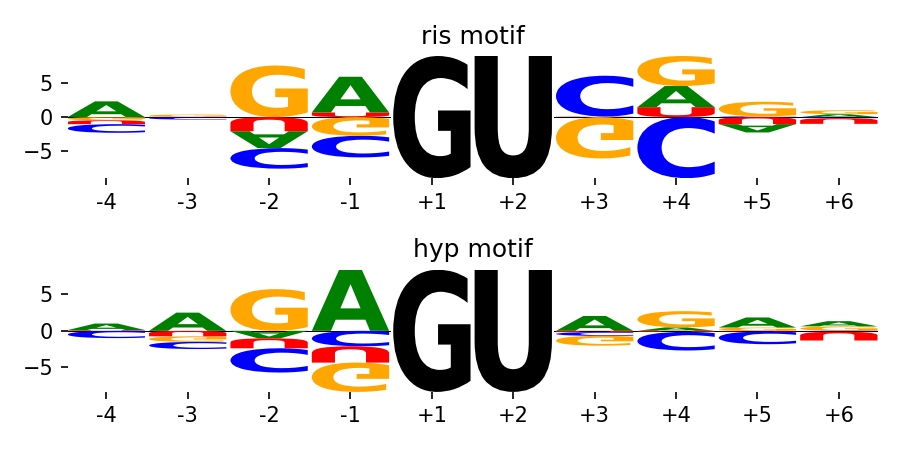

In [11]:
# To convert samples to logos
def samples_to_logo_df(theta_lc_samples):
    theta_lc_mean = np.array(theta_lc_samples.mean(axis=0))
    logo_df =  pd.DataFrame(theta_lc_mean, columns=['A', 'C', 'G', 'U'])
    zeros_df = pd.DataFrame(np.zeros([2,4]), columns=['A', 'C', 'G', 'U'])
    logo_df = pd.concat([logo_df.iloc[:4,:], zeros_df, logo_df.iloc[4:]], axis=0).reset_index(drop=True)
    logo_df.index = range(-4,6)    
    return logo_df

# Define plotting function
def plot_logo(theta_lc_mean_df, ax, drug_name):
    logo = logomaker.Logo(theta_lc_mean_df, ax=ax, center_values=True, show_spines=False)
    logo.highlight_position_range(pmin=0, pmax=1, color='w', zorder=1)
    ylim = ax.get_ylim()
    logomaker.Glyph(ax=ax, p=0, c='G', color='k', floor=ylim[0], ceiling=ylim[1])
    logomaker.Glyph(ax=ax, p=1, c='U', color='k', floor=ylim[0], ceiling=ylim[1])
    ax.set_title(f'{drug_name}');
    ax.set_xticks(theta_lc_mean_df.index)
    x_ticks_labels = ['-4', '-3', '-2', '-1', '+1', '+2', '+3', '+4', '+5', '+6']
    ax.set_xticklabels(x_ticks_labels)
    ax.set_ylim(ylim)
    plt.tight_layout()

# Plot logos
fig, axs = plt.subplots(2,1, figsize=(6, 3))

# Risdiplam logo
theta_lc_ris_df = samples_to_logo_df(mcmc_samples['theta_lc_ris'])
plot_logo(theta_lc_ris_df, axs[0], 'ris motif')

# Hyper logo
theta_lc_hyp_df = samples_to_logo_df(mcmc_samples['theta_lc_hyp'])
plot_logo(theta_lc_hyp_df, axs[1], 'hyp motif')

<IPython.core.display.Javascript object>


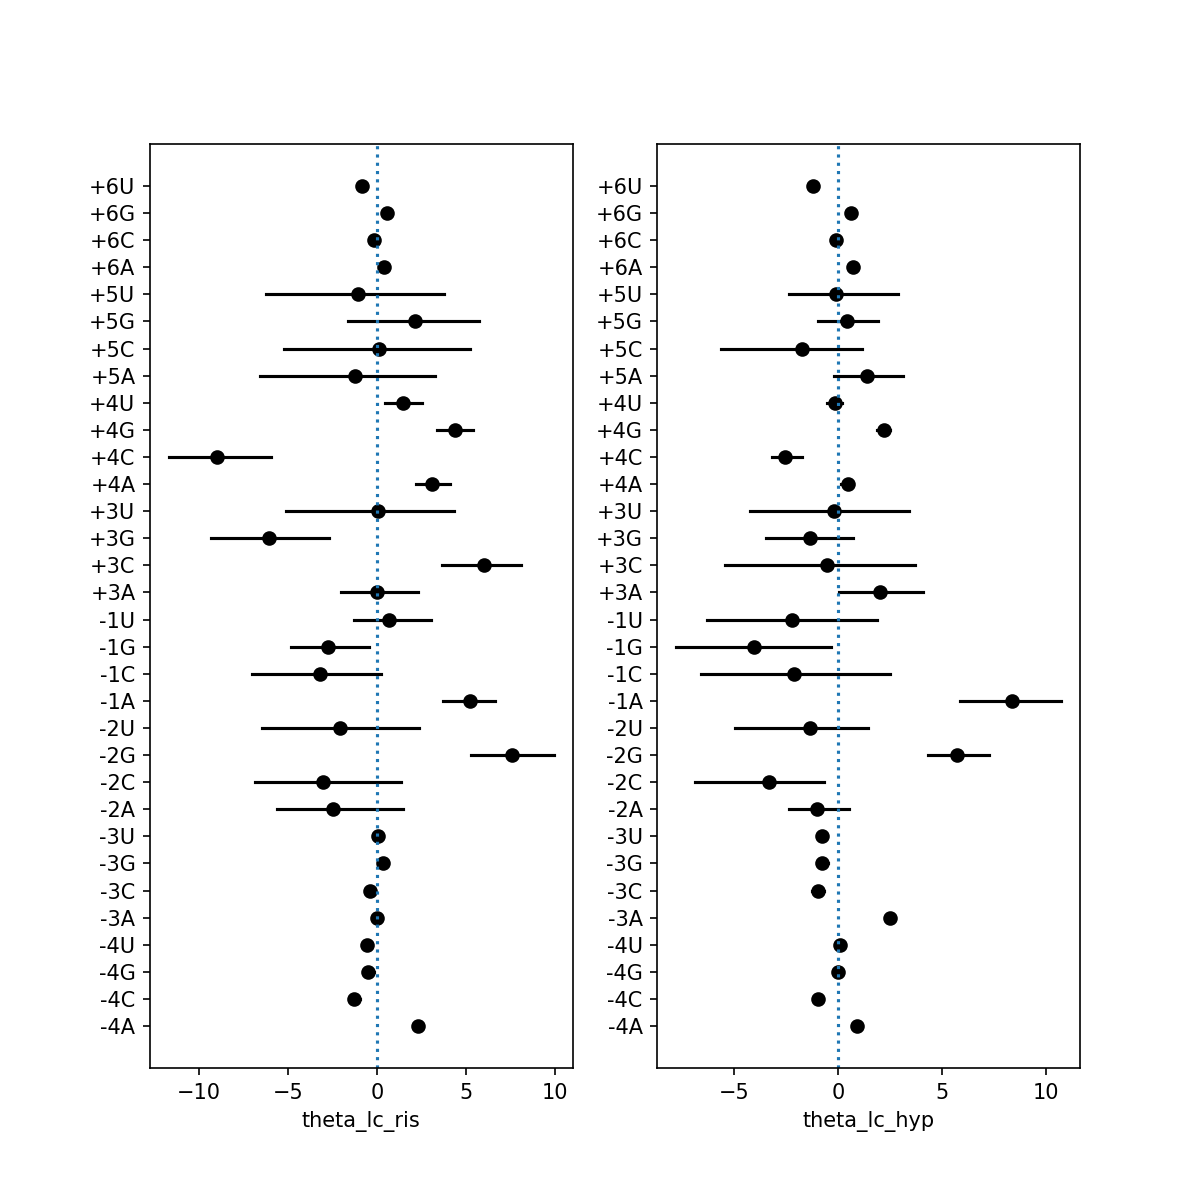

In [12]:
# Plot matrix values and uncertainties
poss = ['-4', '-3', '-2', '-1', '+3', '+4', '+5', '+6']
bases = list('ACGU')

fig, axs = plt.subplots(1,2,figsize=[8,8])
for ax, theta_lc_name in zip(axs, ['theta_lc_ris', 'theta_lc_hyp']):
    
    # Get theta_lc samples and fix gauge
    theta_lc_samples = np.array(mcmc_samples[theta_lc_name])
    theta_lc_samples = theta_lc_samples - theta_lc_samples.mean(axis=2)[:,:,np.newaxis]

    theta_lc_mean = theta_lc_samples.mean(axis=0)
    theta_lc_hpdi = hpdi(theta_lc_samples, prob=.9, axis=0)
    
    # Fuck, have to gauge fix mcmc_samples first
    
    yticks = []
    yticklabels = []
    for i, pos in enumerate(poss):
        for j, base in enumerate(bases):
            y = 4*i + j
            x = theta_lc_mean[i,j]
            x_lo = theta_lc_hpdi[0,i,j]
            x_hi = theta_lc_hpdi[1,i,j]
            ax.plot(x,y,'ok')
            ax.plot([x_lo, x_hi],[y, y],'-k')
            yticks.append(y)
            yticklabels.append(f'{pos}{base}')
            
    # Style plot
    ax.axvline(0,linestyle=':')
    ax.set(yticks=yticks,
           yticklabels=yticklabels,
           xlabel=theta_lc_name)

<IPython.core.display.Javascript object>


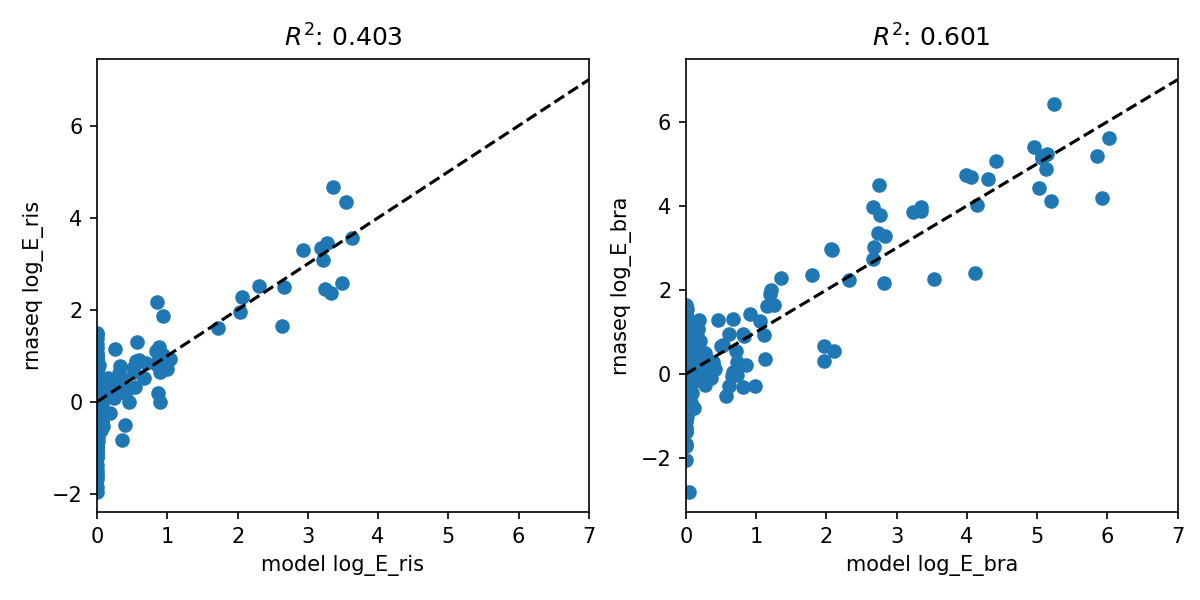

In [13]:
# Plot E_ris and E_bran measured vs. predicted
ix = measurement_df['use_for_rnaseq_fit']

log_E_ris_model = np.log(np.array(mcmc_samples['E_ris'].mean(axis=0)))[ix]
log_E_ris_data = measurement_df['log_E_risdiplam'].values[ix]

log_E_bra_model = np.log(np.array(mcmc_samples['E_bra'].mean(axis=0)))[ix]
log_E_bra_data = measurement_df['log_E_branaplam'].values[ix]

def my_rsq(x_values, y_values):
    correlation_matrix = np.corrcoef(x_values, y_values)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    return r_squared

def plot(ax, x, y, xlabel, ylabel):
    ax.scatter(x,y)
    xlim=[0,7]
    ax.plot(xlim, xlim, '--k')
    ax.set(xlabel=xlabel,
           ylabel=ylabel,
           title=f'$R^2$: {my_rsq(x,y):.3f}',
           xlim=xlim)

fig, axs = plt.subplots(1,2,figsize=[8,4])
    
plot(ax = axs[0],
     x=log_E_ris_model,
     y=log_E_ris_data,
     xlabel='model log_E_ris',
     ylabel='rnaseq log_E_ris')
    
plot(ax = axs[1],
     x=log_E_bra_model,
     y=log_E_bra_data,
     xlabel='model log_E_bra',
     ylabel='rnaseq log_E_bra')

fig.tight_layout()

<IPython.core.display.Javascript object>


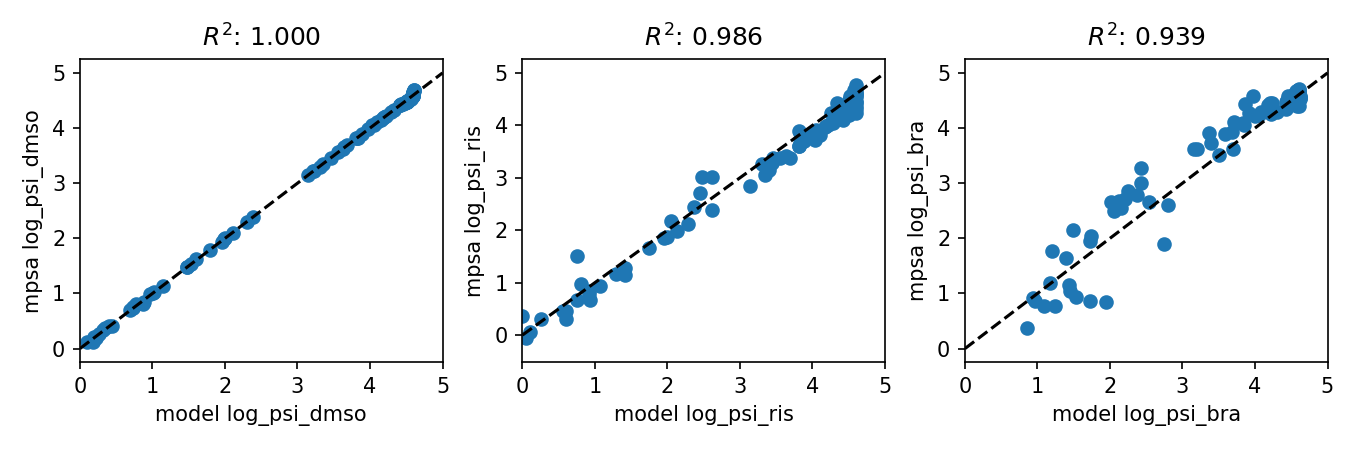

In [14]:
# Plot log_psi (measured vs. predicted) for dmso, risdiplam, branaplam

ix = measurement_df['use_for_mpsa_fit']

log_psi_dmso_model = np.array(mcmc_samples['log_psi_dmso'].mean(axis=0))[ix]
log_psi_dmso_data = measurement_df['log_psi_dmso'].values[ix]

log_psi_ris_model = np.array(mcmc_samples['log_psi_ris'].mean(axis=0))[ix]
log_psi_ris_data = measurement_df['log_psi_risdiplam'].values[ix]

log_psi_bra_model = np.array(mcmc_samples['log_psi_bra'].mean(axis=0))[ix]
log_psi_bra_data = measurement_df['log_psi_branaplam'].values[ix]

def plot(ax, x, y, xlabel, ylabel):
    ax.scatter(x,y)
    xlim=[0,5]
    ax.plot(xlim, xlim, '--k')
    ax.set(xlabel=xlabel,
           ylabel=ylabel,
           title=f'$R^2$: {my_rsq(x,y):.3f}',
           xlim=xlim)

fig, axs = plt.subplots(1,3,figsize=[9,3])

plot(ax = axs[0],
     x=log_psi_dmso_model,
     y=log_psi_dmso_data,
     xlabel='model log_psi_dmso',
     ylabel='mpsa log_psi_dmso')

plot(ax = axs[1],
     x=log_psi_ris_model,
     y=log_psi_ris_data,
     xlabel='model log_psi_ris',
     ylabel='mpsa log_psi_ris')

plot(ax = axs[2],
     x=log_psi_bra_model,
     y=log_psi_bra_data,
     xlabel='model log_psi_bra',
     ylabel='mpsa log_psi_bra')

fig.tight_layout()
